In [74]:
from urllib.request import urlopen
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

import os
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *

OFF_API_PATH = "https://world.openfoodfacts.org/{}.json"
OFF_API_QUERY_PATH = "https://world.openfoodfacts.org/cgi/search.pl?{}&page_size=1000&action=process&json=1"
figsize=(10, 6)

dfConso = pd.read_csv("../data/Table_conso.csv", sep=";", encoding="ansi")
dfIndiv = pd.read_csv("../data/Table_indiv.csv", sep=";", encoding="ansi")
dfCapiCA = pd.read_csv("../data/Table_capi_ca.csv", sep=";", encoding="ansi")
dfCarnetCA = pd.read_csv("../data/Table_carnet_ca_1.csv", sep=";", encoding="ansi")
dfIndivCA = pd.read_csv("../data/Table_indiv_ca.csv", sep=";", encoding="ansi")
dfIndnut = pd.read_csv("../data/Table_indnut.csv", sep=";", encoding="ansi")
dfMenage = pd.read_csv("../data/Table_menage_1.csv", sep=";", encoding="ansi")
dfRepas = pd.read_csv("../data/Table_repas.csv", sep=";", encoding="ansi")
dfNomenclature = pd.read_csv("../data/Nomenclature_3.csv", sep=";", encoding="ansi")
dfCorrespondance = pd.read_csv("../data/correspondance_reponses.csv", sep=";", encoding="ansi")
dfDataNames = pd.read_csv("../data/Data_names_all.csv", sep=";", encoding="ansi")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (150,151,152,153,154,155) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Table_capi_ca.csv
Table_carnet_ca_1.csv
Table_conso.csv
Table_indiv.csv
Table_indiv_ca.csv
Table_indnut.csv
Table_menage_1.csv
Table_repas.csv
correspondance_reponses.csv

In [2]:
dfCorrespondance.head(10)

,Libellé du codage,code,Signification
0,a5gglo,1,rural
1,a5gglo,2,2 000 à 20 000 hab.
2,a5gglo,3,20 000 à 100 000 hab.
3,a5gglo,4,> 100 000 hab
4,a5gglo,5,agglo paris
5,a9gglo,1,rural
6,a9gglo,2,2 000 à 5 000 hab.
7,a9gglo,3,5 000 à 10 000 hab.
8,a9gglo,4,10 000 à 20 000 hab.
9,a9gglo,5,20 000 à 50 000 hab.


In [3]:
dfDataNames.head(5)

,Nom de la variable,Type,Libellé du codage,Libellé de la variable
0,achapub,Numérique,pub,Demande à acheter des produits pour lesquels i...
1,achpub1,Numérique,achpub,A acheté Aliment 1 - Publicité
2,achpub2,Numérique,achpub,A acheté Aliment 2 - Publicité
3,achpub3,Numérique,achpub,A acheté Aliment 3 - Publicité
4,achpub4,Numérique,achpub,A acheté Aliment 4 - Publicité


In [4]:
dfDataCorrespondance = dfDataNames.merge(dfCorrespondance,left_on="Libellé du codage", right_on="Libellé du codage", how="inner")

In [5]:
def findCorrespondance(val, column):
    """
    Returns the correspondance of the numerical val for the corresponding column.
    """
    try:
        meaning = dfDataCorrespondance[(dfDataCorrespondance["Nom de la variable"] == column) & (dfDataCorrespondance["code"] == val)]["Signification"].values[0]
    except IndexError:
        meaning = val
    return meaning

def mapCorrespondances(vals, column):
    """
    Returns the correspondance of the numerical val for the corresponding column.
    """
    return [findCorrespondance(val, column) for val in vals]

def findDescription(column):
    """
    Returns the description of the column signification.
    """
    return dfDataNames[(dfDataNames["Nom de la variable"] == column)]["Libellé de la variable"].values[0]

def mapDescription(columns):
    """
    Returns the description of the columns signification.
    """
    return [findDescription(column) for column in columns]

In [6]:
marqCounts = dfConso\
    .groupby("libmarq")\
    .agg({"codal": "count"}, as_index=False)\
    .rename(columns={"codal": "count"})\
    .sort_values("count", ascending=False)
marqCounts

,count
libmarq,
x,305523
carrefour,8077
cristaline,6537
leader price,6528
auchan,6344
u,4622
champion,3530
coca cola,3453
dia,3297


In [7]:
print("Brands with more than one item: {} / {}".format(len(marqCounts[marqCounts["count"] > 1]), len(marqCounts)))

Brands with more than one item: 3885 / 7234


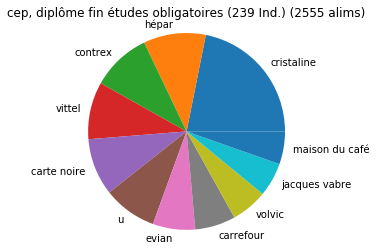

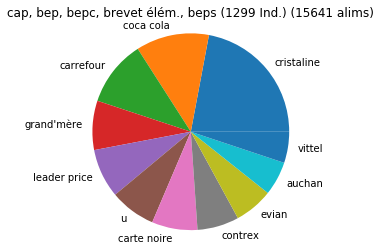

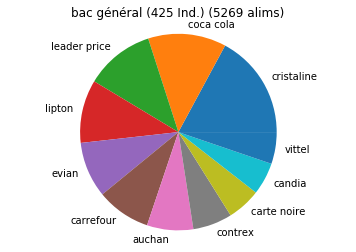

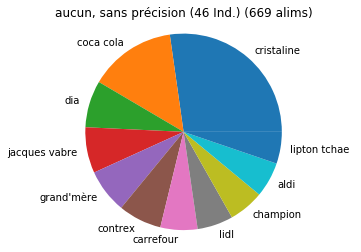

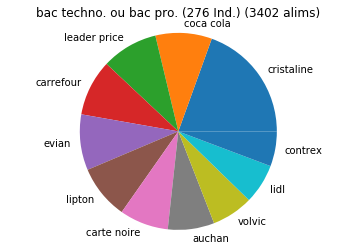

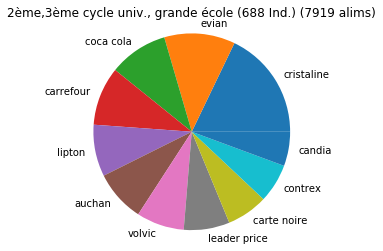

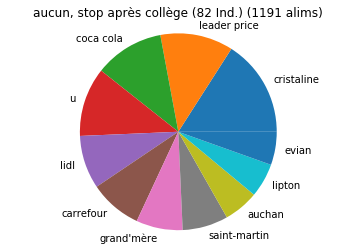

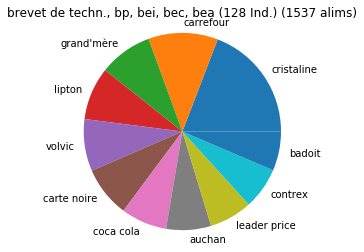

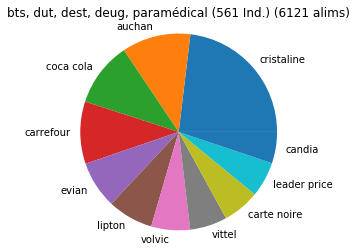

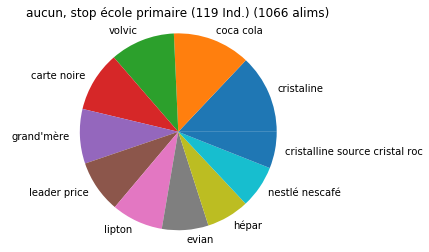

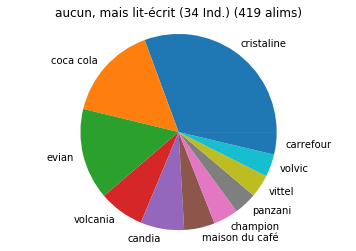

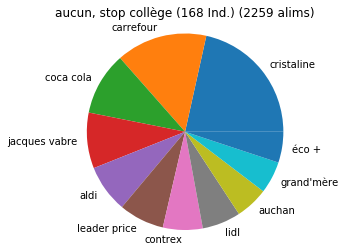

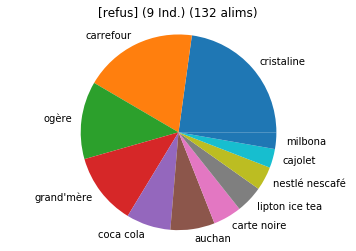

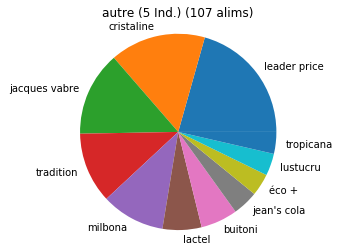

In [8]:
df = dfIndiv.merge(dfConso, left_on="nomen", right_on="nomen", how="inner")
dfBrands = df.groupby(["dip", "libmarq"], as_index=False).agg({"codal": "count", "qte_nette": "sum"}).rename(columns={"codal": "count"})
#dfBrands = dfBrands[dfBrands["count"] > 3]

diplomes = df["dip"].unique()
feature = "qte_nette"

for diplome in diplomes:
    fig, ax = plt.subplots()
    dfBrandsDiplomes = dfBrands[dfBrands.dip == diplome].sort_values(feature, ascending=False)
    ax.pie(x = dfBrandsDiplomes[feature][1:12], labels = dfBrandsDiplomes.libmarq[1:12])
    ax.axis("equal")
    ax.set_title("{} ({} Ind.) ({} alims)".format(findCorrespondance(diplome, "dip"), dfIndiv[dfIndiv["dip"] == diplome].shape[0], dfBrandsDiplomes["count"][1:12].sum()))
plt.show()

# Openfoodfacts

In [9]:
result = json.load(urlopen(OFF_API_PATH.format("brands")))

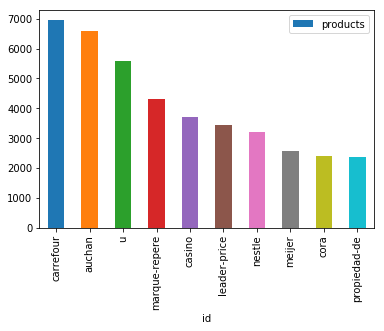

In [10]:
df = pd.DataFrame.from_records(result["tags"])
df.head(10).plot.bar(x="id", y="products")
plt.show()

In [75]:
def getOFFDataFrame(adress, path = OFF_API_PATH):
    result = json.load(urlopen(path.format(adress)))
    print("{} entries gathered".format(result["count"]))
    if "products" in result:
        return pd.DataFrame(result["products"])
    return pd.DataFrame(result["tags"])

def getOFFDataFrameDict(qdict):
    q = "&".join(["{}={}".format(key, value) for key, value in qdict.items()])
    return getOFFDataFrame(q, OFF_API_QUERY_PATH)


In [12]:
labelsDf = getOFFDataFrame("labels")
labelsDf = labelsDf.sort_values("products", ascending=False)

10157 entries gathered


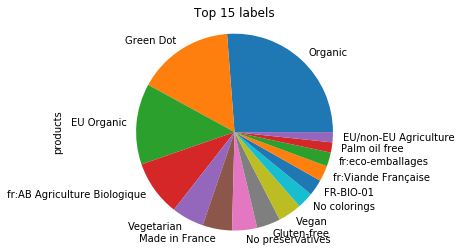

In [76]:
df = labelsDf.head(15)
df.plot.pie(labels=df["name"], y="products", legend=False)
plt.axis("equal")
plt.title("Top 15 labels")
plt.show()

8046 entries gathered


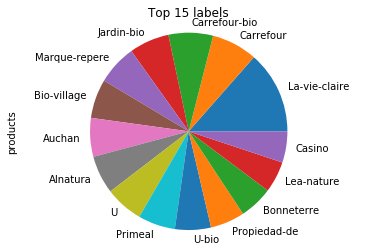

In [77]:
organicBrandsDf = getOFFDataFrame("label/organic/brands")
organicBrandsDf = organicBrandsDf.sort_values("products", ascending=False)
df = organicBrandsDf.head(15)
df.plot.pie(labels=df["name"], y="products", legend=False)
plt.axis("equal")
plt.title("Top 15 labels")
plt.show()

In [107]:
organicBrandsDf = getOFFDataFrameDict({"tagtype_0": "labels", "tag_contains_0": "contains","tag_0": "organic"})


37889 entries gathered


In [121]:
dfNomenclature.groupby("codgr", "sougr").agg({"libgr": "max", "libgr": "max"})

ValueError: No axis named codsougr for object type <class 'pandas.core.frame.DataFrame'>

In [108]:
organicBrand = 
organicBrand["nbrands"] = 1./(organicBrand["brands"].str.count(pat =", ")+1)
organicBrand = organicBrand.select(explode(organicBrand["brands"].str.split(pat =", ", expand=False)).alias("brand"))
organicBrand = organicBrand.groupby("brand").agg({"brand": "max", "nbrands": "sum"}).rename(columns = {"_id":"products"})
organicBrand = organicBrand.sort_values("products", ascending=False)
df = organicBrand.head(15)
df.plot.pie(labels=df["brands"], y="products", legend=False)
plt.axis("equal")
plt.title("Top 15 labels")
plt.show()

TypeError: Invalid argument, not a string or column: 0                                                  Bjorg
1                                                  Bjorg
2                                       Rigoni di Asiago
3                                                 Lactel
4                                                  Bjorg
5                                                  heinz
6                                                  Bjorg
7                             Bjorg,Distribjorg Pays-Bas
8                                                  Bjorg
9                                              Alter Eco
10                                                 Bjorg
11                               Carrefour bio,Carrefour
12                                            Jardin Bio
13                                      Rigoni di Asiago
14                                                 Bjorg
15                                               Jordans
16                                             Carrefour
17                                                 Bjorg
18                                                 Bjorg
19                 Les 2 Vaches,Stonyfield France,Danone
20                                                 Bjorg
21                                                 Bjorg
22                                            Céréal Bio
23                                                 Bjorg
24                               St Hubert,St Hubert Bio
25                                                 Bjorg
26                                                 Bjorg
27                               Carrefour,Carrefour BIO
28                                      Bjorg,Distriborg
29                                            Céréal Bio
                             ...                        
970                                           Céréal Bio
971                                           Céréal Bio
972                                    Casino,Casino Bio
973                                               Casino
974                                     Bjorg,Distriborg
975                                                Bjorg
976                                                Bjorg
977                                                Bjorg
978                                                Bjorg
979                                                Bjorg
980                                                Bjorg
981                                                Bjorg
982                                                Bjorg
983                                                Bjorg
984                                                Bjorg
985                                            Carrefour
986                              Carrefour,Carrefour Bio
987                                        Carrefour Bio
988                                Monoprix Bio,Monoprix
989                      Pâturages,Sélection Intermarché
990    Regain,Sélection des Mousquetaires,Les Mousque...
991                                              Odyssée
992                                             Chabrior
993                                             chabrior
994                                               Ivoria
995                                      Grandeur nature
996                                             Pressade
997                                             U Bio, U
998                                              U Bio,U
999                                             U Bio, U
Name: brands, Length: 1000, dtype: object of type <class 'pandas.core.series.Series'>. For column literals, use 'lit', 'array', 'struct' or 'create_map' function.

In [115]:
explode(organicBrand["brands"].str.split(pat =",", expand=False))

TypeError: Invalid argument, not a string or column: 0                                                [Bjorg]
1                                                [Bjorg]
2                                     [Rigoni di Asiago]
3                                               [Lactel]
4                                                [Bjorg]
5                                                [heinz]
6                                                [Bjorg]
7                          [Bjorg, Distribjorg Pays-Bas]
8                                                [Bjorg]
9                                            [Alter Eco]
10                                               [Bjorg]
11                            [Carrefour bio, Carrefour]
12                                          [Jardin Bio]
13                                    [Rigoni di Asiago]
14                                               [Bjorg]
15                                             [Jordans]
16                                           [Carrefour]
17                                               [Bjorg]
18                                               [Bjorg]
19             [Les 2 Vaches, Stonyfield France, Danone]
20                                               [Bjorg]
21                                               [Bjorg]
22                                          [Céréal Bio]
23                                               [Bjorg]
24                            [St Hubert, St Hubert Bio]
25                                               [Bjorg]
26                                               [Bjorg]
27                            [Carrefour, Carrefour BIO]
28                                   [Bjorg, Distriborg]
29                                          [Céréal Bio]
                             ...                        
970                                         [Céréal Bio]
971                                         [Céréal Bio]
972                                 [Casino, Casino Bio]
973                                             [Casino]
974                                  [Bjorg, Distriborg]
975                                              [Bjorg]
976                                              [Bjorg]
977                                              [Bjorg]
978                                              [Bjorg]
979                                              [Bjorg]
980                                              [Bjorg]
981                                              [Bjorg]
982                                              [Bjorg]
983                                              [Bjorg]
984                                              [Bjorg]
985                                          [Carrefour]
986                           [Carrefour, Carrefour Bio]
987                                      [Carrefour Bio]
988                             [Monoprix Bio, Monoprix]
989                   [Pâturages, Sélection Intermarché]
990    [Regain, Sélection des Mousquetaires, Les Mous...
991                                            [Odyssée]
992                                           [Chabrior]
993                                           [chabrior]
994                                             [Ivoria]
995                                    [Grandeur nature]
996                                           [Pressade]
997                                          [U Bio,  U]
998                                           [U Bio, U]
999                                          [U Bio,  U]
Name: brands, Length: 1000, dtype: object of type <class 'pandas.core.series.Series'>. For column literals, use 'lit', 'array', 'struct' or 'create_map' function.

In [14]:
countriesDf = getOFFDataFrame("countries")
countriesDf = countriesDf.sort_values("products", ascending=False)

244 entries gathered


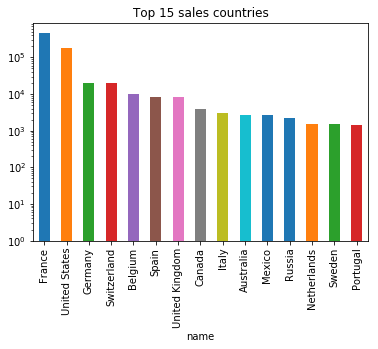

In [15]:
df = countriesDf.head(15)
df.plot.bar(x="name", y="products", legend=False, log=True)
plt.title("Top 15 sales countries")
plt.show()

In [57]:
ingredientsDf = getOFFDataFrame("nutrient-levels")
ingredientsDf = ingredientsDf.sort_values("products", ascending=False)
ingredientsDf

23 entries gathered


,id,name,products,url
0,en:sugars-in-low-quantity,Sugars in low quantity,76033,https://world.openfoodfacts.org/nutrient-level...
1,en:saturated-fat-in-low-quantity,Saturated fat in low quantity,70177,https://world.openfoodfacts.org/nutrient-level...
2,en:salt-in-low-quantity,Salt in low quantity,69260,https://world.openfoodfacts.org/nutrient-level...
3,en:fat-in-low-quantity,Fat in low quantity,58763,https://world.openfoodfacts.org/nutrient-level...
4,en:sugars-in-high-quantity,Sugars in high quantity,56442,https://world.openfoodfacts.org/nutrient-level...
5,en:salt-in-moderate-quantity,Salt in moderate quantity,54315,https://world.openfoodfacts.org/nutrient-level...
6,en:fat-in-moderate-quantity,Fat in moderate quantity,52229,https://world.openfoodfacts.org/nutrient-level...
7,en:saturated-fat-in-high-quantity,Saturated fat in high quantity,46716,https://world.openfoodfacts.org/nutrient-level...
8,en:fat-in-high-quantity,Fat in high quantity,40595,https://world.openfoodfacts.org/nutrient-level...
9,en:saturated-fat-in-moderate-quantity,Saturated fat in moderate quantity,31919,https://world.openfoodfacts.org/nutrient-level...


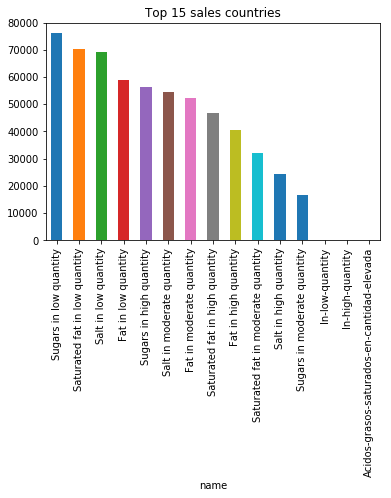

In [17]:
ingDf = ingredientsDf.head(15)
ingDf.plot.bar(x="name", y="products", legend=False)
plt.title("Top 15 sales countries")
plt.show()

In [18]:
result = json.load(urlopen(OFF_API_PATH.format("country/france/2")))
for k, v in result.items():
    try:
        print(k, len(v))
    except:
        print(k, v)

page 1
count 450875
skip 20
products 20
page_size 20


In [19]:
def findKey(data):
    for k, v in data.items():
        if isinstance(v, list):
            return k

def gatherOFFDataFramePages(adress, pages = None):
    result = json.load(urlopen(OFF_API_PATH.format(adress)))
    count = result["count"]
    key = findKey(result)
    df = pd.DataFrame(result[key])
    if "page" in result.keys():
        nbPages = (count - 1) // result["page_size"] + 1
        if pages != None:
            nbPages = np.min([nbPages, pages])
        for i in range(2, nbPages+1):
            currResult = json.load(urlopen(OFF_API_PATH.format(adress + "/" + str(i))))
            currDf = pd.DataFrame(currResult[key])
            df = df.append(currDf, sort=False)
            print(i, df["_id"].count())
    return df

In [20]:
franceDf = gatherOFFDataFramePages("country/france", 5)
franceDf[["_id", "product_name", "labels", "ingredients_text", "last_modified_t", "brands"]].head(100)

2 40
3 60
4 80
5 100


,_id,product_name,labels,ingredients_text,last_modified_t,brands
0,3270720300354,Cacahuètes caramélisées,,,1542972995,Daco Bell
1,3272320013405,Milleret Ser Francuski Roucoulons,NaN,NaN,1542972979,NaN
2,3588400258384,Citronnettes,NaN,NaN,1542972967,NaN
3,3700353615124,Patate douce biologique,NaN,NaN,1542972908,NaN
4,2000000083848,NaN,NaN,NaN,1542972892,NaN
5,8410261777160,Zumo 100% Exprimido Veggies,NaN,NaN,1542972890,NaN
6,8410261604619,Zumo de manzana,,Zumo de manzana concentrado y acidulante: ácid...,1542972865,Don Simón
7,7613036242172,rick&mix,NaN,NaN,1542972852,NaN
8,3701138105380,"Salade de poulet, boulgour, patate douce",NaN,NaN,1542972818,NaN
9,3251320020422,Les Gros Bio 4 Oeufs Bio Fermiers,"Sans OGM,AB Agriculture Biologique,Bio europée...",4 _œufs_ bio fermiers,1542972764,Loué


In [21]:
for x in franceDf.columns:
    print(x)

_id
_keywords
additives_debug_tags
additives_n
additives_old_n
additives_old_tags
additives_original_tags
additives_prev_n
additives_prev_original_tags
additives_prev_tags
additives_tags
allergens
allergens_debug_tags
allergens_from_ingredients
allergens_from_user
allergens_hierarchy
allergens_tags
amino_acids_prev_tags
amino_acids_tags
brands
brands_debug_tags
brands_tags
categories
categories_debug_tags
categories_hierarchy
categories_prev_hierarchy
categories_prev_tags
categories_tags
checkers
checkers_tags
cities_tags
code
codes_tags
complete
completed_t
correctors
correctors_tags
countries
countries_beforescanbot
countries_debug_tags
countries_hierarchy
countries_tags
created_t
creator
debug_param_sorted_langs
debug_tags
editors
editors_tags
emb_codes
emb_codes_20141016
emb_codes_debug_tags
emb_codes_orig
emb_codes_tags
empty
entry_dates_tags
expiration_date
expiration_date_debug_tags
fruits-vegetables-nuts_100g_estimate
generic_name
generic_name_de
generic_name_de_debug_tags
gene

In [22]:
spark = SparkSession.builder.getOrCreate()
sqlContext = sqlContext = SQLContext(spark)

In [23]:
DATA_DIR = "../data/"
if os.path.exists(DATA_DIR+"openfoodfacts.parquet"):
    productsDf = spark.read.parquet(DATA_DIR + "openfoodfacts.parquet")
    #productsDf.show(2)
else:
    productsDf = spark.read.csv(DATA_DIR+'en.openfoodfacts.org.products.csv', header=True, sep="	") #load the dataset into a Spark dataframe
    #productsDf.show(2) #show the content (20 first rows)
    productsDf.write.parquet(DATA_DIR+"openfoodfacts.parquet", mode="overwrite") #save it in the Parquet format

for (k, v) in productsDf.dtypes:
    print("{: <20}:{}".format(k, v))

code                :string
url                 :string
creator             :string
created_t           :string
created_datetime    :string
last_modified_t     :string
last_modified_datetime:string
product_name        :string
generic_name        :string
quantity            :string
packaging           :string
packaging_tags      :string
brands              :string
brands_tags         :string
categories          :string
categories_tags     :string
categories_en       :string
origins             :string
origins_tags        :string
manufacturing_places:string
manufacturing_places_tags:string
labels              :string
labels_tags         :string
labels_en           :string
emb_codes           :string
emb_codes_tags      :string
first_packaging_code_geo:string
cities              :string
cities_tags         :string
purchase_places     :string
stores              :string
countries           :string
countries_tags      :string
countries_en        :string
ingredients_text    :string
allergens

In [24]:
dfConsoAll = dfConso.merge(dfIndiv, left_on="nomen", right_on="nomen", how="inner")

In [25]:
def plotBar(table, idx, col, x):
    consos = table[[col, idx, x]].groupby([idx, col]).count().unstack(level=1)[x]
    consos = consos.swapaxes(0,1)
    consos = consos / consos.sum(axis=0)
    consos = consos.swapaxes(0,1)
    consos.index = mapCorrespondances(consos.index, idx)
    consos.columns = mapCorrespondances(consos.columns, col)
    consos.plot.bar(stacked=True)
    plt.show()

def plotScatter(table, col1, col2):
    data = table[[col1, col2]].values
    plt.scatter(data[:,0], data[:,1])
    plt.show()
    
def getBinsFunc(x, nbins):
    xmin = np.min(x)
    xmax = np.max(x) * 1.01
    return lambda v: np.int16(nbins * (v - xmin) / (xmax - xmin)) * (xmax - xmin) + xmin
    
def plotScatterCateX(table, x, y, index, bins):
    consos = table[[x, y, index]]
    f = getBinsFunc(consos[y], bins)
    consos[y] = f(consos[y])
    plotBar(consos, x, y, index)
    

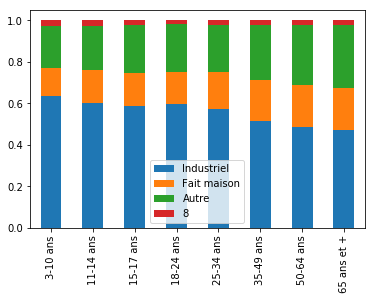

In [26]:
plotBar(dfConsoAll, "tage", "typal3", "numlig")

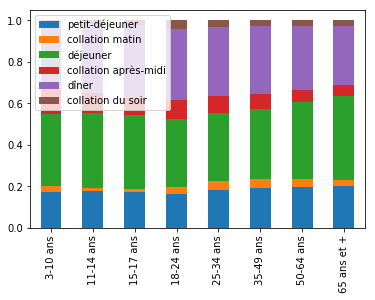

In [27]:
plotBar(dfConsoAll, "tage", "tyrep", "numlig")

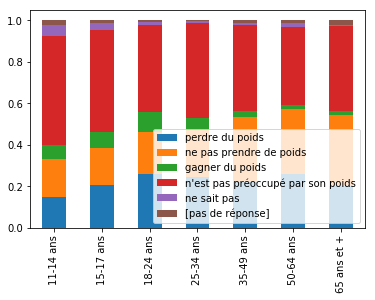

In [28]:
plotBar(dfIndiv, "tage", "essaipds", "nomen")

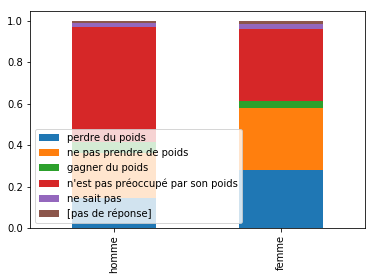

In [29]:
plotBar(dfIndiv, "sexe_ps", "essaipds", "nomen")

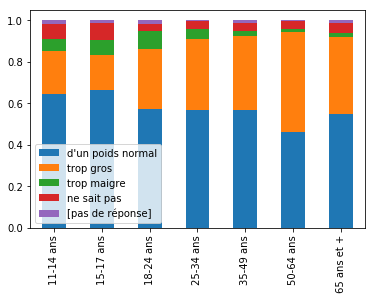

In [30]:
plotBar(dfIndiv, "tage", "opipoids", "nomen")

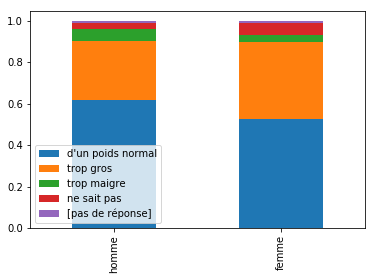

In [31]:
plotBar(dfIndiv, "sexe_ps", "opipoids", "nomen")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


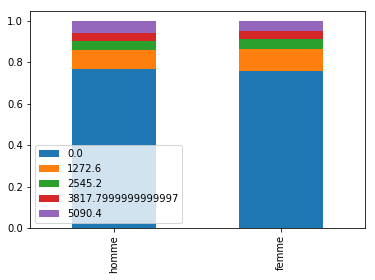

In [32]:
plotScatterCateX(dfIndiv, "sexe_ps", "modere_hebdo", "nomen", 5)

# Inference

In [33]:
from sklearn.decomposition import PCA

In [34]:
def plotPCAComponents(table, features, trainIndex = None, nbComps=4):
    # Train PCA
    data = table[features].values
    
    if trainIndex is None:
        trainIndex = np.ones(len(data), "bool")

    trainData = data[trainIndex]

    mu = np.mean(trainData, axis=0)
    sigma = np.std(trainData, axis=0)

    trainData = (trainData - mu) / sigma

    pca = PCA()
    pca.fit(trainData)
    
    #Show PCA first comps
    featuresNames = mapDescription(features)
    
    cumComponents = np.zeros(len(features))
    fig, ax = plt.subplots(figsize=figsize)
    for i in range(nbComps):
        components = np.abs(pca.components_[i, :])
        ax.bar(featuresNames, components, bottom=cumComponents)
        cumComponents += components
    plt.xticks(fontsize=12, rotation=90)
    plt.show()

In [35]:
def plotMeanValues(table, features, className, mincount=50):
    featuresNames = mapDescription(features)

    means = table.groupby(className).filter(lambda x: len(x) > mincount).groupby(className).mean()[features]
    means.columns = featuresNames
    means /= means.sum(axis=0)
    means = means.swapaxes(0, 1)
    means.columns = mapCorrespondances(means.columns, className)
    means.plot.bar(stacked=True, figsize=figsize)
    plt.show()

In [36]:
table = dfIndnut.merge(dfIndiv, left_on="nomen", right_on="nomen", how="inner")
className = "tage"
samples = "nomen"
cateFeatures = []
numFeatures = np.array(["nutj{}".format(i) for i in range(4, 29)] + ["nutj{}".format(i) for i in range(30, 40)])
featuresNames = mapDescription(numFeatures)

data = table[numFeatures].values
labels = table[className].values

trainIndex = np.ones(len(data), "bool")
trainIndex[np.arange(int(len(data) * 0.8))] = False

trainData = data[trainIndex]
testData = data[~trainIndex]
trainLabels = labels[trainIndex]
testLabels = labels[~trainIndex]

mu = np.mean(trainData, axis=0)
sigma = np.std(trainData, axis=0)

trainData = (trainData - mu) / sigma
testData = (testData - mu) / sigma


pca = PCA()
pca.fit(trainData)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

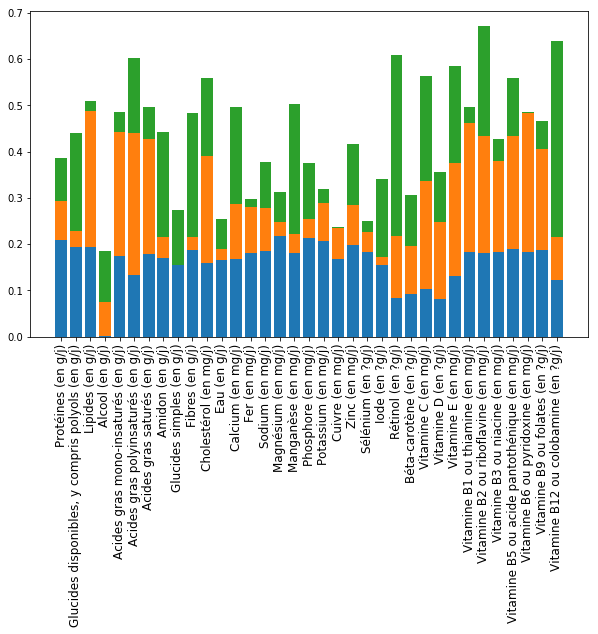

In [37]:
nbComps = 3
cumComponents = np.zeros(len(numFeatures))
fig, ax = plt.subplots(figsize=figsize)
for i in range(nbComps):
    components = np.abs(pca.components_[i, :])
    ax.bar(featuresNames, components, bottom=cumComponents)
    cumComponents += components
plt.xticks(fontsize=12, rotation=90)
plt.show()

In [38]:
indnutIndTable = dfIndnut.merge(dfIndiv, left_on="nomen", right_on="nomen", how="inner")
columns = {col:col[:-2] for col in indnutIndTable.columns if col[-2:] == "_x"}
dropColumns = [col for col in indnutIndTable.columns if col[-2:] == "_y"]
indnutIndTable = indnutIndTable.rename(columns = columns).drop(columns= dropColumns)

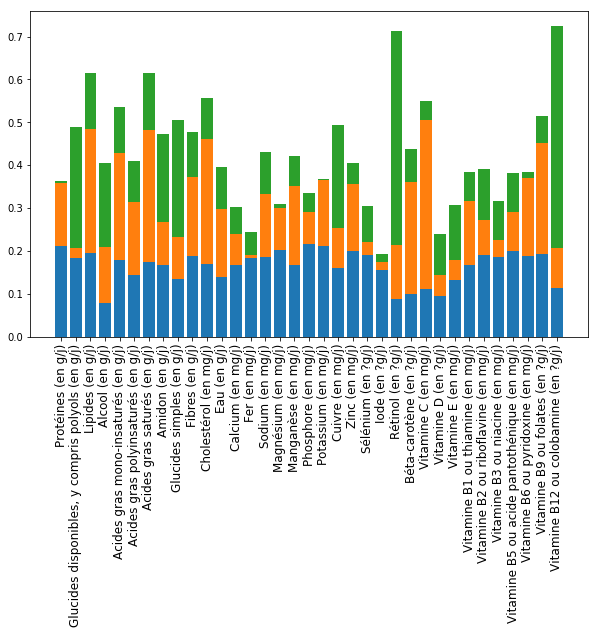

In [39]:
plotPCAComponents(indnutIndTable, numFeatures, nbComps=3)

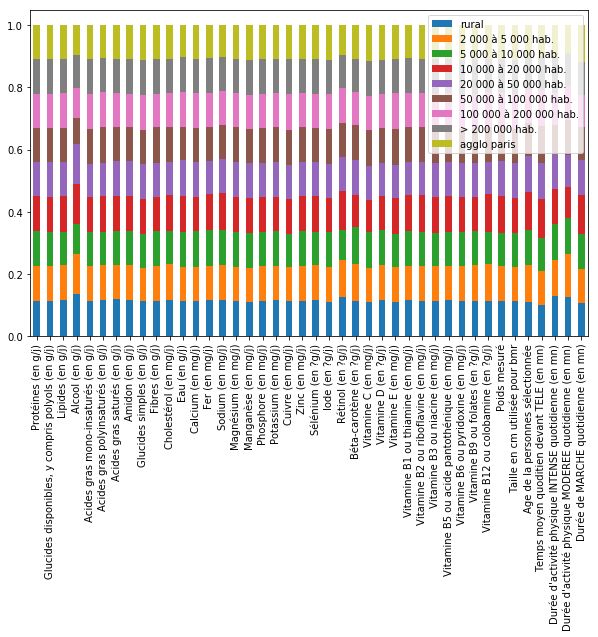

In [40]:
className = "agglo9"
samples = "nomen"
cateFeatures = []
numFeatures = ["nutj{}".format(i) for i in range(4, 29)] + ["nutj{}".format(i) for i in range(30, 40)] + ["poidsm", "taille", "v2_age", "tele", "intense_j", "modere_j", "marche_j"]
featuresNames = mapDescription(numFeatures)

table = indnutIndTable
means = table.groupby(className).mean()[numFeatures]
means.columns = featuresNames
means /= means.sum(axis=0)
means = means.swapaxes(0, 1)
means.columns = mapCorrespondances(means.columns, className)
means.plot.bar(stacked=True, figsize=figsize)
plt.show()

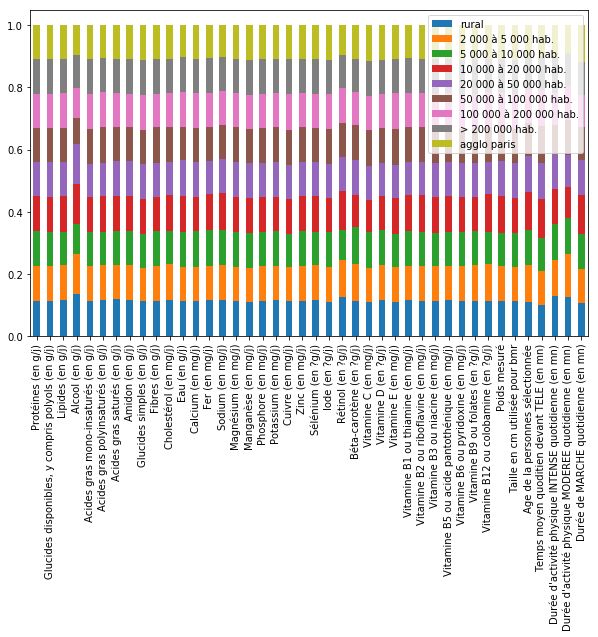

In [41]:
plotMeanValues(indnutIndTable, numFeatures, "agglo9")

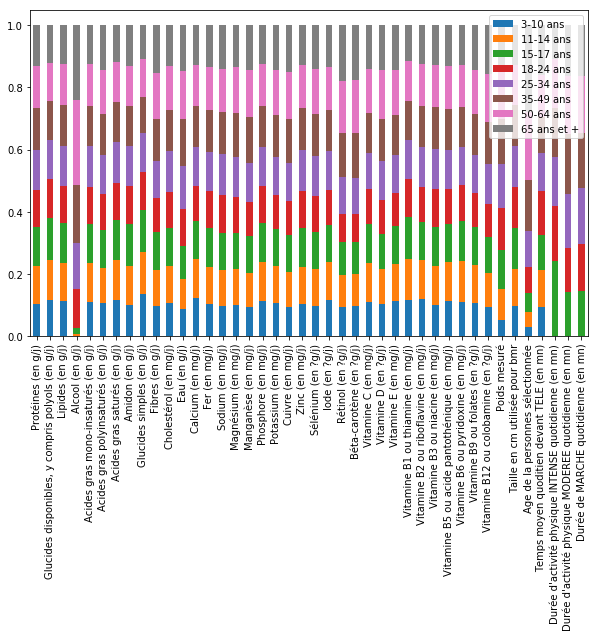

In [42]:
plotMeanValues(indnutIndTable, numFeatures, "tage")

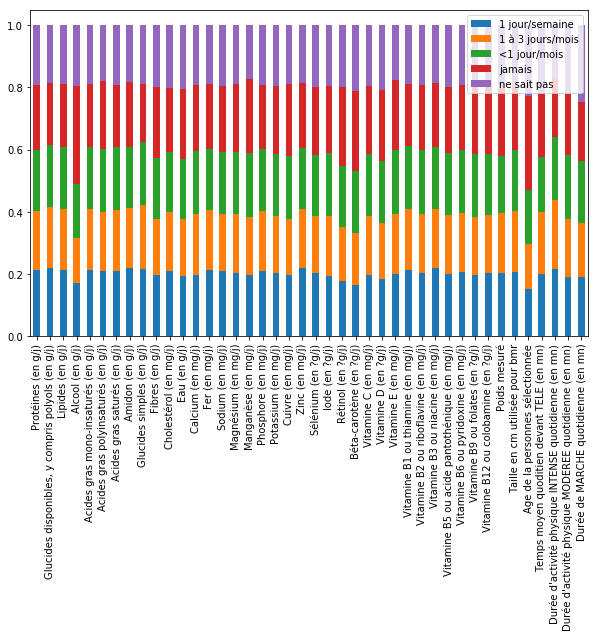

In [43]:
plotMeanValues(indnutIndTable, numFeatures, "fastfood")

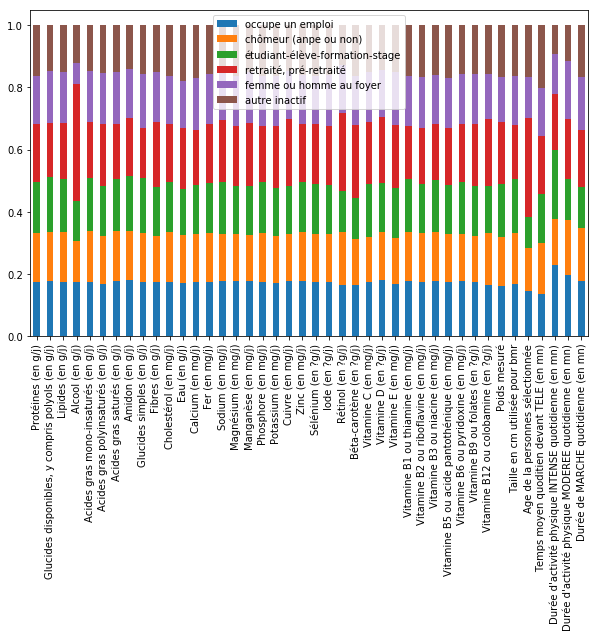

In [44]:
plotMeanValues(indnutIndTable, numFeatures, "situ_prof")

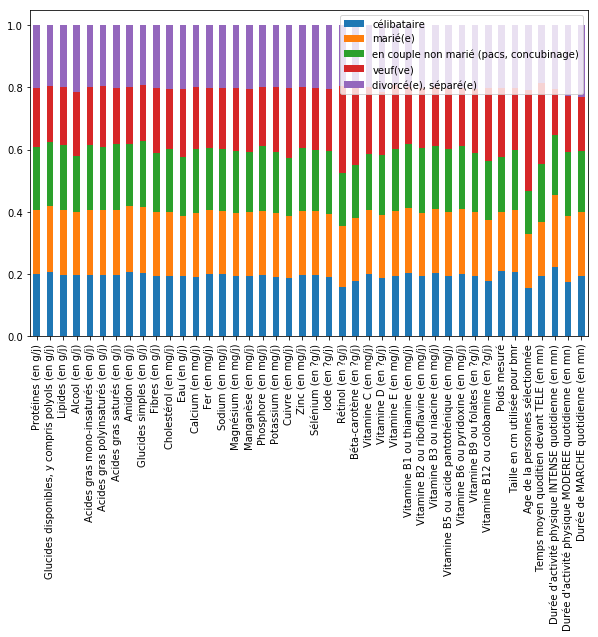

In [45]:
plotMeanValues(indnutIndTable, numFeatures, "situ_mat")

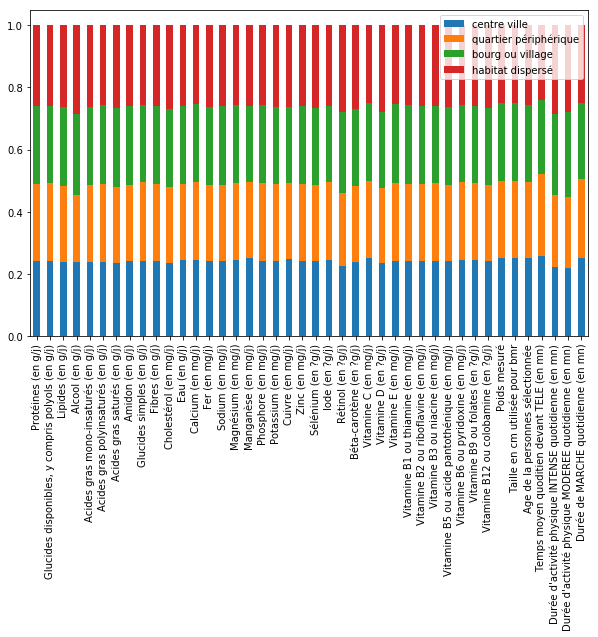

In [46]:
plotMeanValues(indnutIndTable, numFeatures, "loc_log")

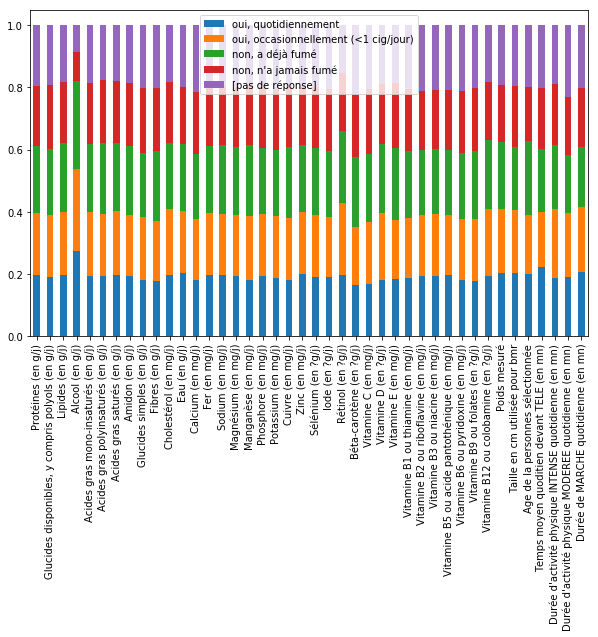

In [47]:
plotMeanValues(indnutIndTable, numFeatures, "fume")

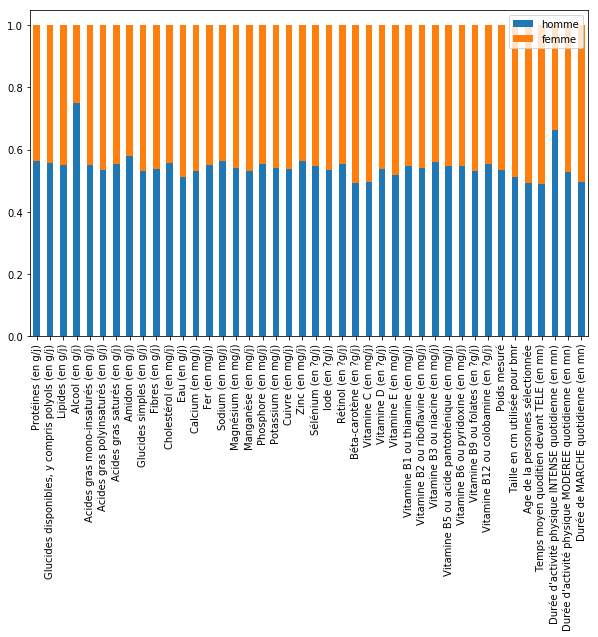

In [48]:
plotMeanValues(indnutIndTable, numFeatures, "sexe_ps")

In [49]:
for col in indnutIndTable.columns:
    print(col)

nomen
sexe_ps
ech
v2_age
aet
nutj4
nutj5
nutj6
nutj7
nutj8
nutj9
nutj10
nutj11
nutj12
nutj13
nutj14
nutj15
nutj16
nutj17
nutj18
nutj19
nutj20
nutj21
nutj22
nutj23
nutj24
nutj25
nutj26
nutj27
nutj28
nutj30
nutj31
nutj32
nutj33
nutj34
nutj35
nutj36
nutj37
nutj38
nutj39
sexeps
fqcantine
entrerep
colmata
distrib
distconf
distfruit
distsoli
fastfood
ffrepas
selassent
selassleg
selassfec
selassvp
selassvps
selassoeuf
enrich
lardcru
sauccru
boeufcru
chevcru
porccru
volcru
poiscru
oeufcru
shboeufcuis
boeufcuis
rotboeufcuis
foiecuis
veaucuis
porccuis
sauccuis
chevcuis
agncuis
cotagncuis
volcuis
intalim
intalinouv
infopub
infoprof
infointern
etiquetad
etiqingr
etiqnut
etiqport
etiqclnut
etiqclsant
bonalim
regimedj
poids12
poids12nsp
essaipds
contalim
contap
opipoids
voeupoids
nbgeneral
nbspecial
pdsmax
agepmax
agepmaxnsp
pdsmin
pdsminnsp
agepmin
agepminnsp
cyclepds
enceinte
allaite
enceinte12
menopaus
ths
fume
nbcigrjm
nbpipejm
nbcigrsm
nbpipesm
agefumem
nbcigrja
nbpipeja
nbcigrsa
nbpipesa
nbcig

In [55]:
dfNomenclature.groupby("libgr").count()

,codgr,sougr,libsougr,codal,libal
libgr,,,,,
-,1,1,1,1,1
abats,17,17,17,17,17
aliments destinés à une alimentation particulière,16,16,16,16,16
autres boissons chaudes,11,11,11,11,11
autres céréales,4,4,4,4,4
autres graisses,6,6,6,6,6
beurre,15,15,15,15,15
biscuits sucrés ou salés et barres,34,34,34,34,34
boissons alcoolisées,38,38,38,38,38


In [52]:
dfNomenclature

,codgr,libgr,sougr,libsougr,codal,libal
0,1,pain et panification sèche,1,pain,7001,pain baguette
1,1,pain et panification sèche,1,pain,7004,pain grillé maison
2,1,pain et panification sèche,1,pain,7012,pain courant français boule à la levure
3,1,pain et panification sèche,1,pain,7100,pain de campagne ou bis
4,1,pain et panification sèche,1,pain,7110,pain complet ou intégral artisanal
5,1,pain et panification sèche,1,pain,7125,pain de seigle et froment
6,1,pain et panification sèche,1,pain,7126,pain de seigle aux raisins
7,1,pain et panification sèche,1,pain,7160,pain baguette sans sel
8,1,pain et panification sèche,1,pain,7200,pain de mie
9,1,pain et panification sèche,1,pain,7225,pain brioché ou viennois


In [56]:
dfConso

,libmarq,typal3,nom_commercial,nomen,numlig,nojour,tyrep,noligne,codgr,sougr,codal,algra,alsuc,enric,diete,rien,typal2,qte_brute,qte_nette
0,summa aldi,2,x,110006,1.0,6,1,1.0,34,99,18151,0.0,0.0,0.0,0.0,1.0,4.0,250.0,250.0
1,tutti free,1,x,110006,2.0,6,1,2.0,30,1,31076,0.0,1.0,0.0,0.0,0.0,4.0,2.5,2.5
2,x,3,x,110006,3.0,6,1,3.0,1,1,7001,0.0,0.0,0.0,0.0,1.0,1.0,30.0,30.0
3,marque repère nadya,1,margarine allégée de tournesol 55%mg,110006,4.0,6,1,4.0,15,99,16632,1.0,0.0,0.0,0.0,0.0,1.0,5.0,5.0
4,albacore,1,x,110006,5.0,6,3,1.0,21,1,26039,0.0,0.0,0.0,0.0,1.0,2.0,30.0,30.0
5,x,2,x,110006,6.0,6,3,2.0,43,1,11110,0.0,0.0,0.0,0.0,1.0,1.0,6.0,6.0
6,x,3,x,110006,7.0,6,3,3.0,1,1,7001,0.0,0.0,0.0,0.0,1.0,1.0,30.0,30.0
7,danone,1,x,110006,8.0,6,3,4.0,10,3,19510,1.0,0.0,0.0,0.0,0.0,1.0,100.0,100.0
8,tutti free,1,x,110006,9.0,6,3,5.0,30,1,31076,0.0,1.0,0.0,0.0,0.0,4.0,2.5,2.5
9,cristaline,1,x,110006,10.0,6,3,6.0,31,4,18008,0.0,0.0,0.0,0.0,1.0,4.0,240.0,240.0
